## Uber Fare Prediction

### Project Objective: 
Design an algorithm which will tell the fare to be charged for a passenger.

### Problem Statement Scenario: 
A fare calculator helps a customer in identifying the fare valid for the trip. They are often used by passengers who are new to a city or tourists to get an estimate of travel costs. You are provided with a dataset with features like fare amount, pickup and drop location, passenger count, and so on.

### Following actions should be performed:
* Understand the type of data.
* Identify the output variable.
* Identify the factors which affect the output variable.
* Check if there are any biases in your dataset.
* Count the null values existing in columns.
* Remove the null value rows in the target variable.
* Perform train test split.
* Predict the accuracy using regression models.
* Check and compare the accuracy of the different models.

## Exploratory Data Analysis

In [1]:
# Import all the required packages
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns
%matplotlib inline

import time
from datetime import datetime

import geopy.distance
from geopy.distance import geodesic

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# The train dataset consists of more than 5M observations.
# We will use a sample of 200,000 observations for this model building.
train = pd.read_csv("train.csv", nrows = 200000) # Read only 200,000 rows
test = pd.read_csv("test.csv")

In [3]:
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Train dataset shape: (200000, 8)
Test dataset shape: (9914, 7)


In [4]:
"""
Here, we will use the longitudes and latitudes in the dataset to calculate
the distance between pickup and dropoff points.
"""

from pyproj import Geod

#Distance will be measured on this ellipsoid - more accurate than a spherical method
wgs84_geod = Geod(ellps = 'WGS84') 

#Get distance between pairs of lat-lon points
def DistanceCalc(lat1, lon1, lat2, lon2):
    # Check on the order. That is the correct order format.
    az12, az21, dist = wgs84_geod.inv(lon1, lat1, lon2, lat2) 
    return dist 

### Train Dataset Exploration and Manipulation

In [5]:
# First few rows of the train dataset.
train.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 12.2+ MB


In [7]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [8]:
# We need to convert the pickup_datetime to DateTime format
train["pickup_datetime"] = pd.to_datetime(train['pickup_datetime'])

In [9]:
train.head(4)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1


### Factors Affecting Price

There are many factors that affects the price of a taxi:

    1. Travelled distance
    2. Total time of travel
    3. Demand and availability of a taxi
    4. Places to travel to. For example, travelling to an airport would be costly than to another normal place.

In [10]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.342877,-72.506121,39.922326,-72.518673,39.925579,1.682445
std,9.837855,11.608097,10.048947,10.724226,6.751120,1.306730
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735007,-73.991295,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967068,40.767127,-73.963508,40.768070,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


### Notes:

    1. Note that the is minimum value of fare is negative which is -44.9 which is not the valid value, so we need to remove the fare values which are negative, just for caution.
    2. Secondly, passenger_count minimum value is 0 and maximum value is 6.   
    3. There are two variables with 1 missing value.    
    4. Finally, the minimum pickup and dropoff longitudes and latitudes have some wierd large values. Probably, there is a problem here.

In [11]:
# Check if there are missing values in the dataset
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [12]:
# The proportion of missing values is very low.
# We are going to drop these values
train.dropna(inplace = True)
print(train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [13]:
# Minimum and maximum longitude and latitudes in the train dataset
print("Drop off latitude min value:",train["dropoff_latitude"].min())
print("Drop off longitude min value:", train["dropoff_longitude"].min())
print("Pickup latitude min value:",train["pickup_latitude"].min())
print("Pickup longitude min value:",train["pickup_longitude"].min())
print()
print("Drop off latitude max value:",train["dropoff_latitude"].max())
print("Drop off longitude max value:",train["dropoff_longitude"].max())
print("Pickup latitude max value:",train["pickup_latitude"].max())
print("Pickup longitude max value:",train["pickup_longitude"].max())

Drop off latitude min value: -1189.61544
Drop off longitude min value: -1251.19589
Pickup latitude min value: -3116.285383
Pickup longitude min value: -736.55

Drop off latitude max value: 404.616667
Drop off longitude max value: 40.851027
Pickup latitude max value: 1703.092772
Pickup longitude max value: 2140.60116


In [14]:
# Minimum and maximum latitude and longitude in the test dataset
print("Drop off latitude min value:",test["dropoff_latitude"].min())
print("Drop off longitude min value:", test["dropoff_longitude"].min())
print("Pickup latitude min value:",test["pickup_latitude"].min())
print("Pickup longitude min value:",test["pickup_longitude"].min())
print()
print("Drop off latitude max value:",test["dropoff_latitude"].max())
print("Drop off longitude max value:",test["dropoff_longitude"].max())
print("Pickup latitude max value:",test["pickup_latitude"].max())
print("Pickup longitude max value:",test["pickup_longitude"].max())

Drop off latitude min value: 40.568973
Drop off longitude min value: -74.263242
Pickup latitude min value: 40.573143
Pickup longitude min value: -74.252193

Drop off latitude max value: 41.696683
Drop off longitude max value: -72.990963
Pickup latitude max value: 41.709555
Pickup longitude max value: -72.986532


**The ranges in the test dataset for drop off and pick up latitudes and longitudes seems to be consistent. We will keep these values and use it on our train dataset. We will remove all the observations on the dataset that are not in the boundaries.**

In [15]:
min_longitude = -74.263242
min_latitude =  40.573143
max_longitude = -72.986532
max_latitude = 41.709555

In [16]:
# Remove all those observations which are not in the boundary above

tempdf = train[(train["dropoff_latitude"] < min_latitude) | 
               (train["pickup_latitude"] < min_latitude) | 
               (train["dropoff_longitude"] < min_longitude) | 
               (train["pickup_longitude"] < min_longitude) | 
               (train["dropoff_latitude"] > max_latitude) | 
               (train["pickup_latitude"] > max_latitude) | 
               (train["dropoff_longitude"] > max_longitude) | 
               (train["pickup_longitude"] > max_longitude) ]

print("Before dropping:", train.shape)
train.drop(tempdf.index, inplace = True)
print("After dropping:",train.shape)

Before dropping: (199999, 8)
After dropping: (195771, 8)


In [17]:
# Remove all the observations with negtaive fare amount

print("Before dropping:", train.shape)
train = train[train['fare_amount'] > 0]
print("After dropping:", train.shape)

Before dropping: (195771, 8)
After dropping: (195755, 8)


In [18]:
# Extract the Days, weeks, months, hour, weekday and year from the datatime column

import calendar
train['day'] = train['pickup_datetime'].apply(lambda x:x.day)
train['hour'] = train['pickup_datetime'].apply(lambda x:x.hour)
train['weekday'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['month'] = train['pickup_datetime'].apply(lambda x:x.month)
train['year'] = train['pickup_datetime'].apply(lambda x:x.year)

In [19]:
train.head(4)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,15,17,Monday,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5,16,Tuesday,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,18,0,Thursday,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,21,4,Saturday,4,2012


In [20]:
# Let's convert the weekday to numerical numbers

train["weekday"] = train["weekday"].map({'Sunday' : 0,
                                         'Monday' : 1,
                                         'Tuesday' : 2,
                                         'Wednesday' : 3,
                                         'Thursday' : 4,
                                         'Friday' : 5,
                                         'Saturday' : 6}
                                       )

In [21]:
train.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011


In [22]:
# we don't need the 'key' and 'pickup_datetime' column anymore

train.drop(["key","pickup_datetime"], 
           axis = 1, 
           inplace = True
          )

In [23]:
train.head(3)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011


In [24]:
train.reset_index(inplace = True, drop = True)

In [25]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010


In [26]:
cols = ["day", "hour", "weekday", "month", "year"]
train[cols] = train[cols].astype('category')

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195755 entries, 0 to 195754
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   fare_amount        195755 non-null  float64 
 1   pickup_longitude   195755 non-null  float64 
 2   pickup_latitude    195755 non-null  float64 
 3   dropoff_longitude  195755 non-null  float64 
 4   dropoff_latitude   195755 non-null  float64 
 5   passenger_count    195755 non-null  int64   
 6   day                195755 non-null  category
 7   hour               195755 non-null  category
 8   weekday            195755 non-null  category
 9   month              195755 non-null  category
 10  year               195755 non-null  category
dtypes: category(5), float64(5), int64(1)
memory usage: 9.9 MB


In [28]:
train.head(3)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011


In [30]:
#Add/update a column to the data frame with the distances (in metres)

train['distance'] = DistanceCalc(train['pickup_latitude'].tolist(),
                             train['pickup_longitude'].tolist(),
                             train['dropoff_latitude'].tolist(),
                             train['dropoff_longitude'].tolist())
# The distance calculated is in Meters (M).
# We need to convert it to Kilometers (KM).
train["distance"] = train["distance"] / 1000

In [31]:
train["distance"].describe()

count    195755.000000
mean          3.331367
std           3.807233
min           0.000000
25%           1.256880
50%           2.155092
75%           3.906262
max         104.101618
Name: distance, dtype: float64

Note that in the above statistics, there are observations to which the distance is 0.0! Let's have a look

In [32]:
distance00 = train[train['distance'] == 0.0]

In [33]:
distance00.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year,distance
102,52.0,-74.035839,40.747320,-74.035839,40.747320,1,25,0,3,3,2009,0.0
187,6.5,-73.998488,40.726303,-73.998488,40.726303,1,8,21,3,1,2014,0.0
264,7.5,-73.995892,40.746454,-73.995892,40.746454,1,25,1,6,8,2012,0.0
283,6.9,-73.982432,40.745747,-73.982432,40.745747,1,14,12,1,12,2009,0.0
386,12.0,-73.844904,40.736318,-73.844904,40.736318,1,12,18,3,3,2014,0.0


In [35]:
# We will drop these observations
print("Observations with Zero distance:", distance00.shape)
print("Before Dropping:", train.shape)
train.drop(distance00.index, inplace = True)
print("After Dropping:", train.shape)

Observations with Zero distance: (2106, 12)
Before Dropping: (195755, 12)
After Dropping: (193649, 12)


In [36]:
train['distance'].describe()

count    193649.000000
mean          3.367597
std           3.811909
min           0.000084
25%           1.282567
50%           2.179881
75%           3.940031
max         104.101618
Name: distance, dtype: float64

## Machine Learning Models

We will be using the **Root Mean Squared Error** to measure the performance of the model:

$$\text{RMSE} = \sqrt{\sum_{i=1}^{n}\frac{(\hat{y}_i - y_i)^2}{n}} $$

In [37]:
X = train.drop("fare_amount", axis = 1)
y = train["fare_amount"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(135554, 11)
(135554,)
(58095, 11)
(58095,)


### Linear Regression Model

In [38]:
## Linear Regression

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

lr_mse = np.sqrt(mean_squared_error(y_pred_lr, y_test))
print("RMSE value for Linear regression is:", lr_mse)

RMSE value for Linear regression is: 5.322787802194042


### Random Forest Regression

In [39]:
## Random Forest Regressor
start_time = time.time()

rfr = RandomForestRegressor(n_estimators = 20, random_state = 101)
rfr.fit(x_train,y_train)
y_pred_rfr = rfr.predict(x_test)

rfr_mse = np.sqrt(mean_squared_error(y_pred_rfr, y_test))

print("RMSE Value for Random Forest Regression is:", rfr_mse)
print("Time taken in seconds is:", time.time() - start_time)

RMSE Value for Random Forest Regression is: 3.8508282060841204
Time taken in seconds is: 150.11984205245972


    * Comparing the two models, we find that Random Forest Regression performs better than Linear Regression and hence we will use it as our final model.
    
    * With the Random Forest Regression model, we can also do hyperperameter estimation for values such as **n_estimators**. For this model, I am using 20 estimators.

In [41]:
rfr.feature_importances_

array([0.0321736 , 0.02001453, 0.04695231, 0.03257563, 0.0033476 ,
       0.011953  , 0.01320681, 0.00741107, 0.00986711, 0.02456442,
       0.79793391])

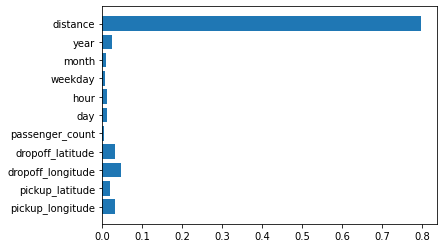

In [46]:
plt.barh(x_train.columns, rfr.feature_importances_)
plt.show()

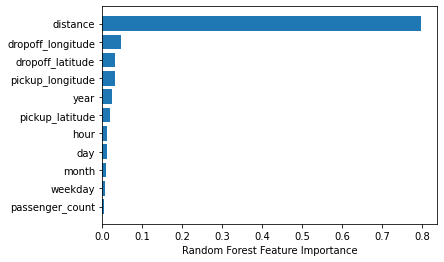

In [47]:
sorted_idx = rfr.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

Notably, passanger count is the least important feature in this model.

## Test Data Preparation

We will follow the same steps as when we were preparing the training data.

In [51]:
test.head(4)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1


In [52]:
test["pickup_datetime"] = pd.to_datetime(test['pickup_datetime'])

In [53]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [54]:
test['day'] = test['pickup_datetime'].apply(lambda x:x.day)
test['hour'] = test['pickup_datetime'].apply(lambda x:x.hour)
test['weekday'] = test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['month'] = test['pickup_datetime'].apply(lambda x:x.month)
test['year'] = test['pickup_datetime'].apply(lambda x:x.year)

In [55]:
test["weekday"] = test["weekday"].map({'Sunday' : 0,
                                         'Monday' : 1,
                                         'Tuesday' : 2,
                                         'Wednesday' : 3,
                                         'Thursday' : 4,
                                         'Friday' : 5,
                                         'Saturday' : 6}
                                       )

In [56]:
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
day                  0
hour                 0
weekday              0
month                0
year                 0
dtype: int64

In [57]:
test.head(4)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,27,13,2,1,2015
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,27,13,2,1,2015
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,8,11,6,10,2011
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1,21,6,12,2012


In [58]:
test.drop(["key","pickup_datetime"], 
           axis = 1, 
           inplace = True
          )

In [59]:
test.head(3)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,-73.973320,40.763805,-73.981430,40.743835,1,27,13,2,1,2015
1,-73.986862,40.719383,-73.998886,40.739201,1,27,13,2,1,2015
2,-73.982524,40.751260,-73.979654,40.746139,1,8,11,6,10,2011


In [60]:
test.reset_index(inplace = True, drop = True)

In [61]:
test['distance'] = DistanceCalc(test['pickup_latitude'].tolist(),
                             test['pickup_longitude'].tolist(),
                             test['dropoff_latitude'].tolist(),
                             test['dropoff_longitude'].tolist())
test["distance"] = test["distance"] / 1000

In [62]:
test["distance"].describe()

count    9914.000000
mean        3.436325
std         3.975529
min         0.000000
25%         1.299267
50%         2.218088
75%         4.045367
max       100.063275
Name: distance, dtype: float64

In [64]:
# We will drop these observations
distancetest00 = test[test["distance"] == 0.0]
print("Observations with Zero distance:", distancetest00.shape)
print("Before Dropping:", test.shape)
test.drop(distancetest00.index, inplace = True)
print("After Dropping:", test.shape)

Observations with Zero distance: (85, 11)
Before Dropping: (9914, 11)
After Dropping: (9829, 11)


In [65]:
test['distance'].describe()

count    9829.000000
mean        3.466042
std         3.979763
min         0.001488
25%         1.320994
50%         2.237029
75%         4.064219
max       100.063275
Name: distance, dtype: float64

In [72]:
cols = ["day", "hour", "weekday", "month", "year"]
test[cols] = test[cols].astype('category')

## Final Model 

### Random Forest Regressor

In [73]:
#from IPython.display import Image
#Image(filename="RandomForest.png")

In [78]:
# Here we will use the whole of train dataset for training
# and then predict the test dataset.

# we will also time to see how long it takes to generate 
# the results
start_time = datetime.now()

rfr_final = RandomForestRegressor(n_estimators = 20, random_state = 101)
rfr_final.fit(X, y)
y_pred_rfr_final = rfr_final.predict(test)

# Save the predictions in a "submission.csv" file
y_pred_final = pd.DataFrame(y_pred_rfr_final)
y_pred_final.columns = ["fare_amount"]
print(y_pred_final.head())
#y_pred_final.to_csv("submission_final.csv", index = False)
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

   fare_amount
0        9.225
1       11.900
2        5.030
3        8.745
4       17.535
Duration: 0:03:19.216098


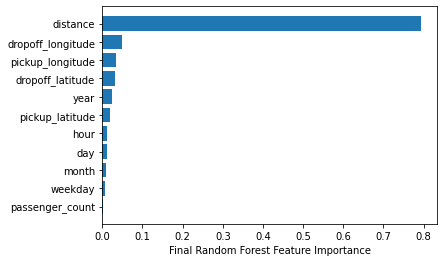

In [79]:
sorted_idx_final = rfr_final.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx_final], 
         rfr_final.feature_importances_[sorted_idx_final])
plt.xlabel("Final Random Forest Feature Importance")
plt.show()

## Next Steps


1. Hyperparameter tuning.

    * number of estimators (n_estimators)
    
2. We pick the most important features in the dataset as in the above feature importance list and generate a Random Forest Model and find out if there is improvement.



### More will be coming with these improvements. Keep Tuned. 
### Happy DataSciencing.